In [1]:
import pathlib
import numpy as np

from fytok.Tokamak import Tokamak
from spdm.view import View as sp_view

data_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")

2023-12-16 10:52:13,397 [    spdm]     INFO: 
###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = alpha  (spdm=beta extension=0.2.2.dev19+g14adade.d20231205, imas_version=v3_38_1_dirty)

 Run by salmon at 2023-12-16T10:52:13.158926.
 Job ID: fytok_salmon_surface_3533

###################################################################################################



In [2]:
tokamak = Tokamak(
    f"file+iterprofiles://{next(data_path.glob('*ASTRA.xls')).absolute().as_posix()}",
    f"file+geqdsk://{next(data_path.glob('**/g*.txt')).absolute().as_posix()}",
    device="iter",
    shot=900003,
    equilibrium={"code": {"parameters": {"psi_norm": np.linspace(0.01, 0.996, 64)}}},
    core_transport={
        "model": [
            {"code": {"name": "dummy"}},
            # {"code": {"name": "fast_alpha"}},
        ]
    },
    core_sources={
        "source": [
            {"code": {"name": "dummy"}},
            # {"code": {"name": "fusion_reaction"}},
            # {"code": {"name": "collisional_equipartition"}},
        ]
    },
    transport_solver={
        "code": {
            "name": "fy_trans",
            "parameters": {
                "rho_tor_norm": np.linspace(0.01, 0.995, 128),
                "bvp_rms_mask": [0.96],
                "hyper_diff": 0.0001,
                "max_nodes": 512,
                "verbose": 2,
            },
        },
        
        "species": ["D"],

        "boundary_condition_type": {
            # fmt: off
            "ion/*/density"              : (2, 1),
            "ion/*/temperature"          : (2, 1),
            "ion/alpha/density"          : (2, 1),
            "ion/alpha/temperature"      : (2, 1),
            "electrons/temperature"      : (2, 1),
            # fmt: on
        },
    },
)

2023-12-16 10:52:13,611 [    spdm]     INFO: Load module spdm.plugins.data.plugin_xml
2023-12-16 10:52:13,793 [    spdm]     INFO: Load module spdm.plugins.data.plugin_iterprofiles
2023-12-16 10:52:13,849 [    spdm]     INFO: Load module spdm.plugins.data.plugin_geqdsk


In [10]:
tokamak.transport_solver.refresh(
    time=0.0,
    initial_value={
        "ion/D/density": 1.0e19,
        "ion/T/density": 1.0e19,
        "ion/He/density": 0.1e19,
        "ion/alpha/density": 0.0,
        "ion/D/temperature": 1000,
        "ion/T/temperature": 1000,
        "ion/He/temperature": 1000,
        "electrons/temperature": 1000,
    },
    boundary_value={
       "ion/D/density"              : ([0.0], [2.0e19]),  #   n_D
       "ion/T/density"              : ([0.0], [2.0e19]),  #   n_T
       "ion/He/density"             : ([0.0], [0.1e19]),    #   n_He
       "ion/alpha/density"          : ([0.0], [2.0e18]),    #   n_alpha
       "ion/D/temperature"          : ([0.0], [1000]),  #   T_D
       "ion/T/temperature"          : ([0.0], [1000]),  #   T_T
       "ion/He/temperature"         : ([0.0], [1000]),      #   T_He
       "electrons/temperature"      : ([0.0], [1000]),        #   T_electron
    },
)

2023-12-16 10:52:23,475 [    spdm]     INFO: Solve transport equations : ion/D/density  ,ion/D/temperature
2023-12-16 10:52:23,482 [    spdm]     INFO: Execute module fytok.plugins.transport_solver_numerics.fy_trans


ValueError: `y` is expected to have 128 columns, but actually has 140.

In [4]:
solver_1d = tokamak.transport_solver.time_slice.current

2023-12-16 10:52:16,442 [    spdm]     INFO: Load module spdm.view.view_matplotlib


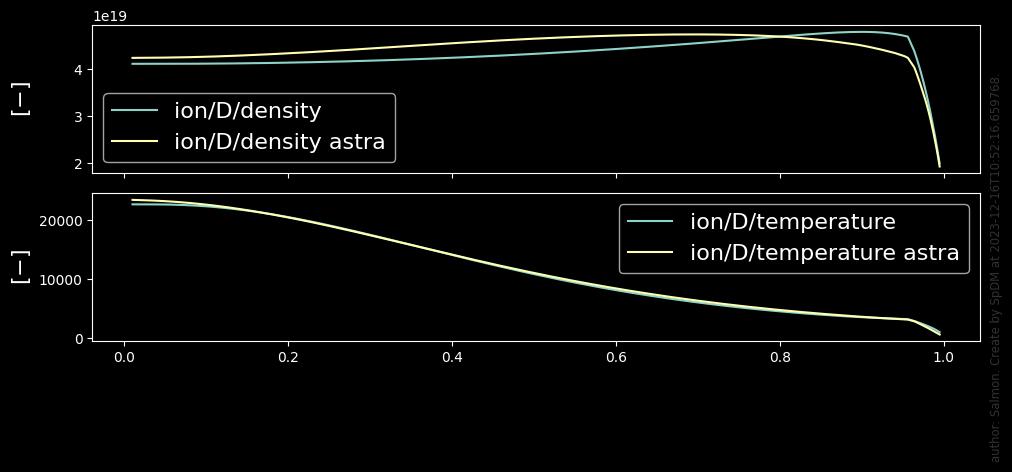

In [5]:
core_profiles_1d = tokamak.core_profiles.time_slice.current.profiles_1d
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    *[
        [
            (equ.profile, rf"{equ.identifier} "),
            (core_profiles_1d.get(equ.identifier) , rf"{equ.identifier} astra"),
        ]
        for equ in solver_1d.equations
    ],
)

In [6]:
t1 = tokamak.core_transport.model[0].time_slice.current
t2 = t1.__copy__()

In [7]:
t1.profiles_1d.ion[0].z

1

In [8]:
t2.profiles_1d.ion[0].z

1

In [9]:
ion.fetch()

NameError: name 'ion' is not defined

In [ ]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    *sum(
        [
            [
                # (equ.profile, equ.identifier),
                # (equ.flux, f"{equ.identifier}_flux"),
                (equ.d_dr, f"d({equ.identifier})/dr"),
                (equ.dflux_dr, f"d({equ.identifier}_flux)/dr"),
            ]
            for equ in solver_1d.equations
        ],
        [],
    ),
)

In [ ]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    *sum(
        [
            [
                (equ.d_dr, f"d({equ.identifier})/dr"),
                (equ.dflux_dr, f"d({equ.identifier}_flux)/dr"),
            ]
            for equ in solver_1d.equations
        ],
        [],
    ),
)

In [ ]:
core_transport_1d = tokamak.core_transport.model[0].time_slice.current.profiles_1d

fig = sp_view.plot(
    core_transport_1d.grid_d.rho_tor_norm,
    (core_transport_1d.electrons.energy.d, r"$\chi_e$"),
    (core_transport_1d.electrons.energy.v, r"$V^{pinch}_{Te}$"),
    # (core_sources_1d.electrons.energy_decomposed.explicit_part, r"$Q_{e}$ explicit"),
    # (core_sources_1d.electrons.energy_decomposed.implicit_part, r"$Q_{e}$ implicit"),
    (core_transport_1d.electrons.particles.d, r"$D_e$"),
    (core_transport_1d.electrons.particles.v, r"$V_e$"),
    *[(ion.energy.d, rf"$\chi_{{{ion.label}}}$") for ion in core_transport_1d.ion],
    *[(ion.energy.v, rf"$V^{{pinch}}_{{T{ion.label}}}$") for ion in core_transport_1d.ion],
    *[(ion.particles.d, rf"$D_{{{ion.label}}}$") for ion in core_transport_1d.ion],
    *[(ion.particles.v, rf"$v_{{{ion.label}}}$") for ion in core_transport_1d.ion],
    x_label=r"$\bar{\rho}_{tor}$",
)

In [ ]:
variables = sum([[equ.profile, equ.flux] for equ in solver_1d.equations], [])
equ = solver_1d.equations[1]
bc0,bc1, a, b, c, d, e, f, g,ym = equ.coefficient
x = solver_1d.grid.rho_tor_norm
# y = equ.profile
# yp = equ.d_dr
# flux = equ.flux
# dflux = equ.dflux_dr
fig = sp_view.plot(
    x,
    # (a(x, *variables), "a"),
    # (b(x, *variables), "b"),
    # (c(x,*vars), "c"),
    (d(x, *variables), "d"),
    (e(x, *variables), "e"),
    (f(x, *variables), "f"),
    # (g(x, *vars), "g"),
    # tokamak.transport_solver.equations[2].d_dr,
    # [
    #     (d*yp, "$D$"),
    #     (e*y,   "$v$"),
    #     # (flux,   f"$\Gamma$"),
    #     ((c*(f - g * y)).I, r"$S$"),  # $\int c*(f - g \cdot y)$
    #     # ((-d*yp+e*y).I, r"$\Gamma$"),
    #     (-d*yp+e*y-(c*(f - g * y)).I, "residual"),
    # ],
    # y, yp
    # [
    #     (dflux, {"label": r"$d\Gamma$"}),
    #     # (Function(flux, x).d(), r"$d\Gamma$"),
    #     ((c*(f - g * y)), r"$c*(f - g \cdot y)$"),
    # ],
)

In [ ]:
fig = sp_view.plot(
    x,
    solver_1d.equations[1].coefficient[5](x, *variables),
    solver_1d.equations[2].coefficient[5](x, *variables),
    solver_1d.equations[3].coefficient[5](x, *variables),
)